<a href="https://colab.research.google.com/github/tkoyama010/Colaboratory/blob/master/Custom_3D_engine_in_Matplotlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom 3D engine in Matplotlib

Reproduction of [Custom 3D engine in Matplotlib](https://matplotlib.org/matplotblog/posts/custom-3d-engine/) by Nicolas P. Rougier

In [1]:
!wget https://matplotlib.org/matplotblog/posts/custom-3d-engine/bunny.obj

--2020-03-31 03:58:20--  https://matplotlib.org/matplotblog/posts/custom-3d-engine/bunny.obj
Resolving matplotlib.org (matplotlib.org)... 104.26.1.8, 104.26.0.8, 2606:4700:20::681a:108, ...
Connecting to matplotlib.org (matplotlib.org)|104.26.1.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205917 (201K) [application/x-tgif]
Saving to: ‘bunny.obj’

bunny.obj           100%[===================>] 201.09K  --.-KB/s    in 0.07s   

2020-03-31 03:58:21 (2.66 MB/s) - ‘bunny.obj’ saved [205917/205917]



In [2]:
!pip install meshio

     |████████████████████████████████| 133kB 1.4MB/s 


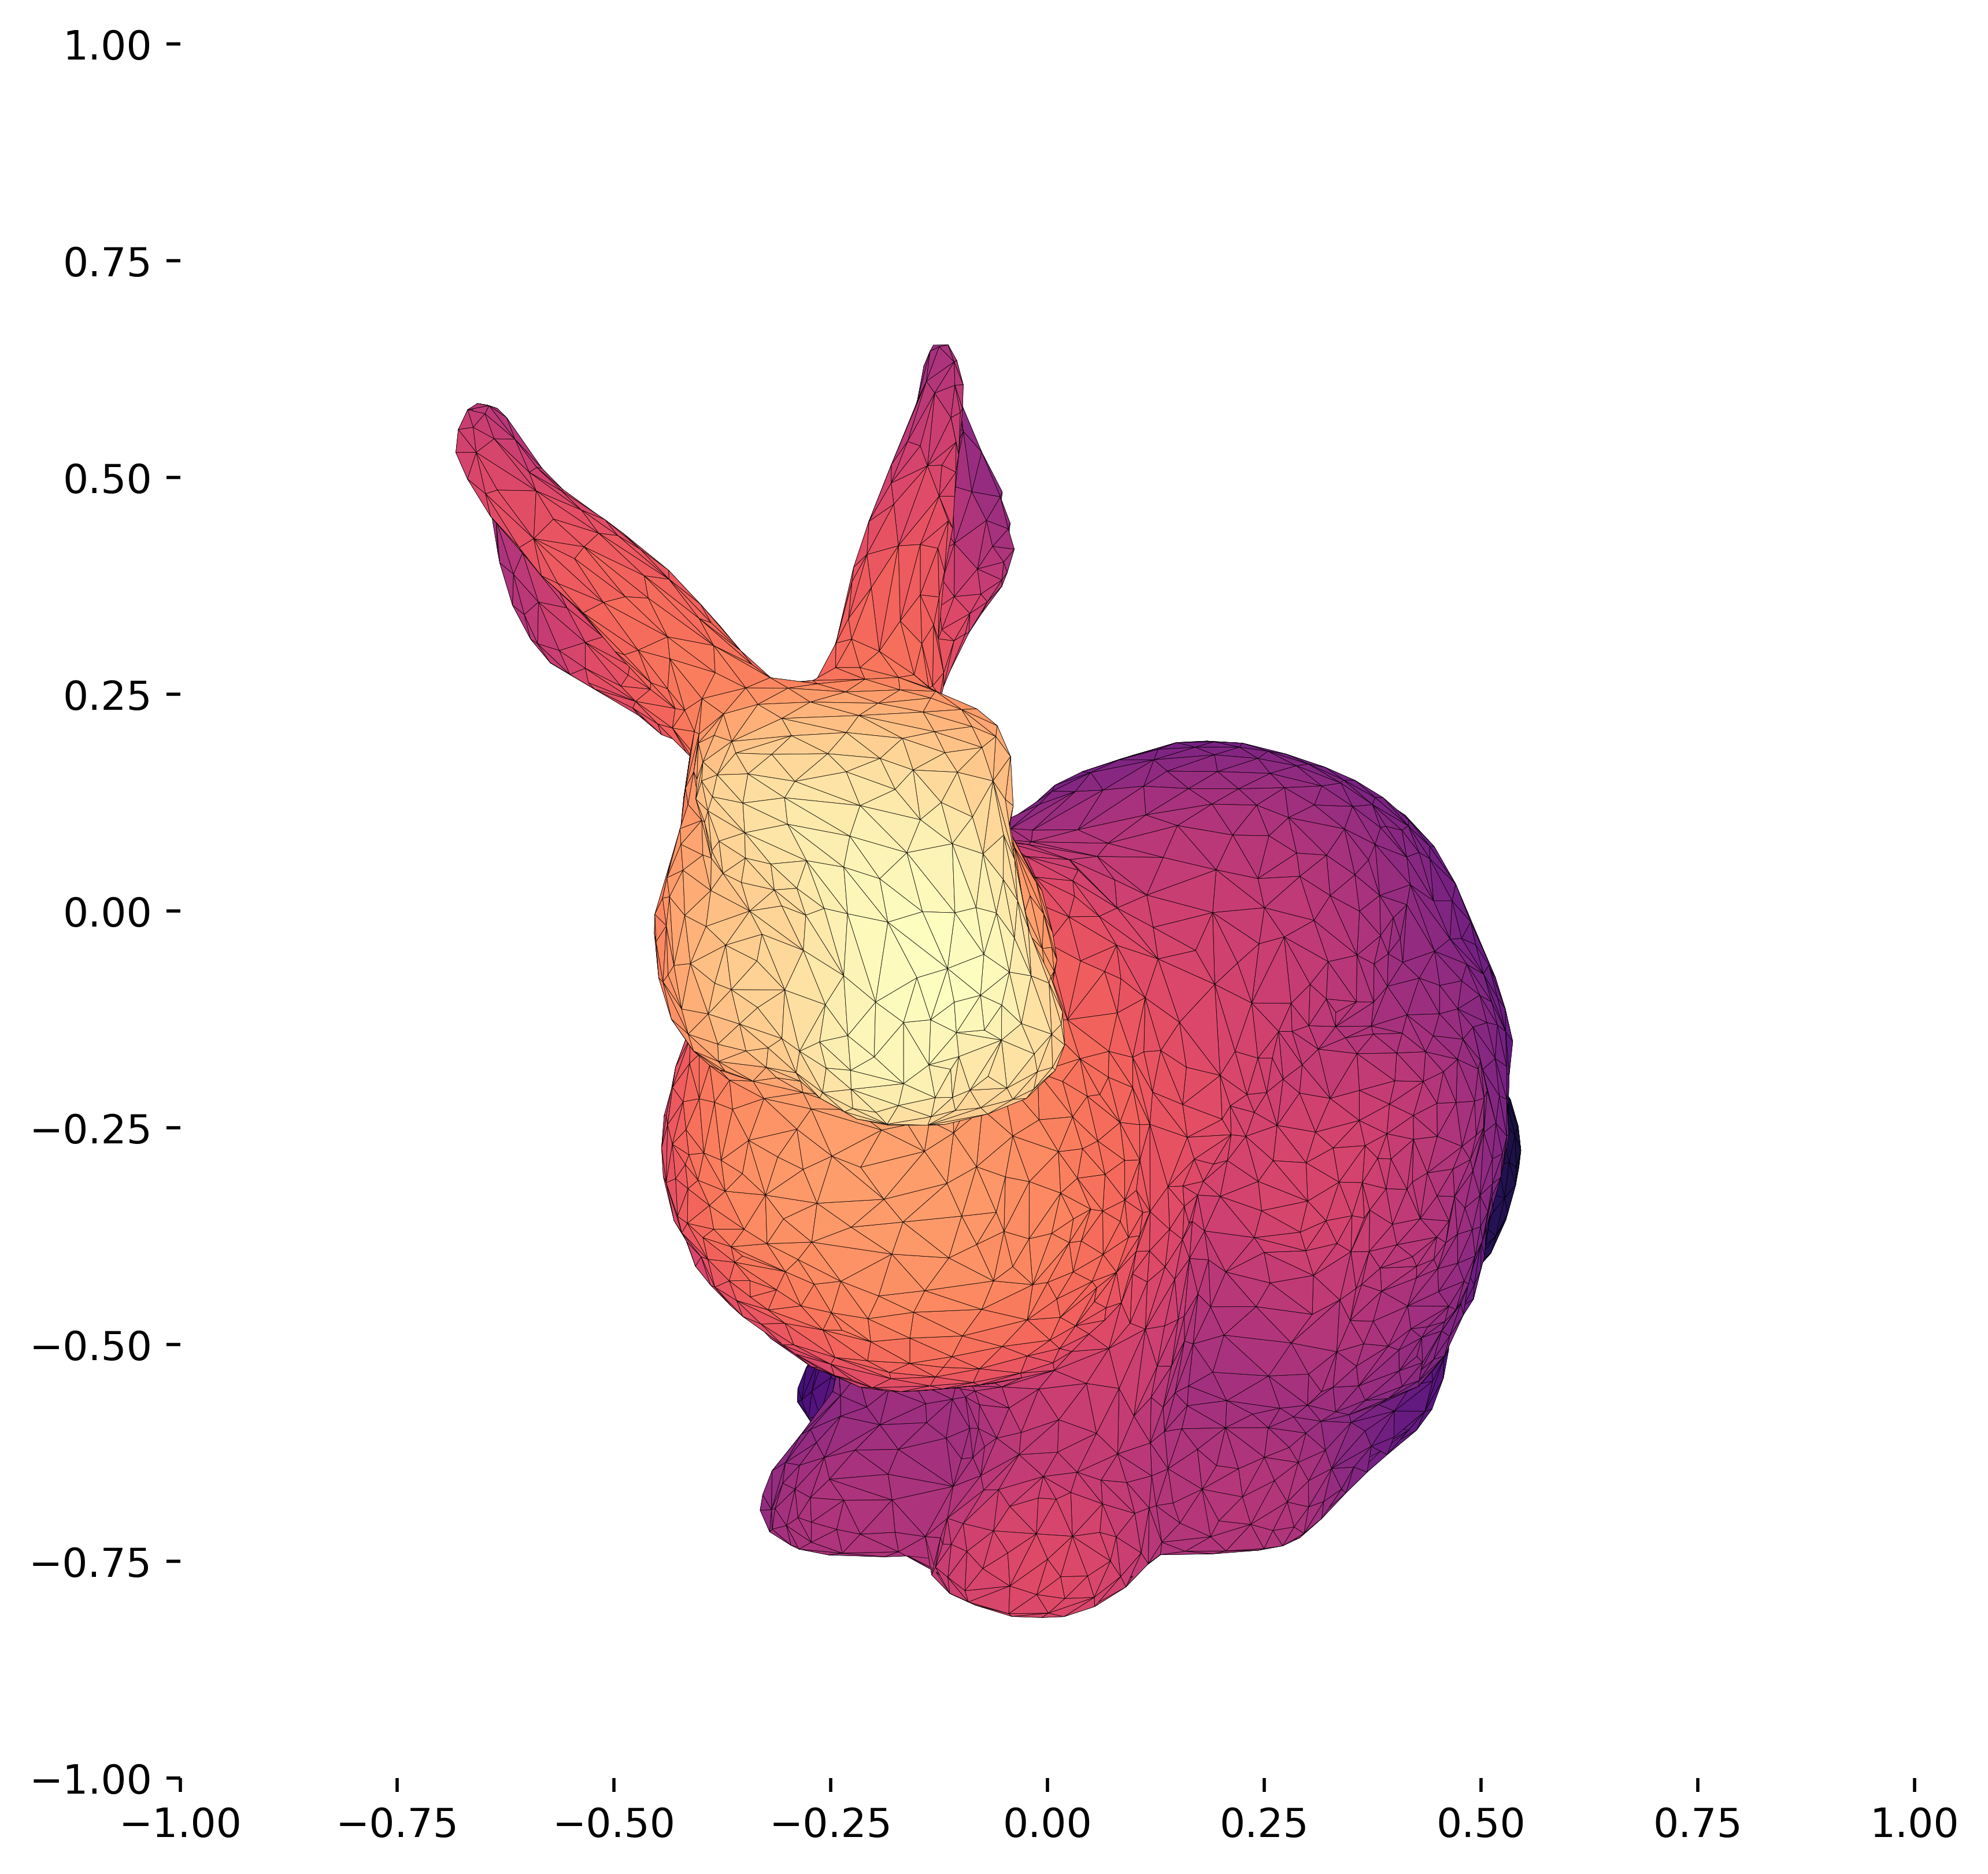

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import meshio

def frustum(left, right, bottom, top, znear, zfar):
    M = np.zeros((4, 4), dtype=np.float32)
    M[0, 0] = +2.0 * znear / (right - left)
    M[1, 1] = +2.0 * znear / (top - bottom)
    M[2, 2] = -(zfar + znear) / (zfar - znear)
    M[0, 2] = (right + left) / (right - left)
    M[2, 1] = (top + bottom) / (top - bottom)
    M[2, 3] = -2.0 * znear * zfar / (zfar - znear)
    M[3, 2] = -1.0
    return M


def perspective(fovy, aspect, znear, zfar):
    h = np.tan(0.5 * np.radians(fovy)) * znear
    w = h * aspect
    return frustum(-w, w, -h, h, znear, zfar)


def translate(x, y, z):
    return np.array(
        [[1, 0, 0, x], [0, 1, 0, y], [0, 0, 1, z], [0, 0, 0, 1]], dtype=float
    )


def xrotate(theta):
    t = np.pi * theta / 180
    c, s = np.cos(t), np.sin(t)
    return np.array(
        [[1, 0, 0, 0], [0, c, -s, 0], [0, s, c, 0], [0, 0, 0, 1]], dtype=float
    )


def yrotate(theta):
    t = np.pi * theta / 180
    c, s = np.cos(t), np.sin(t)
    return np.array(
        [[c, 0, s, 0], [0, 1, 0, 0], [-s, 0, c, 0], [0, 0, 0, 1]], dtype=float
    )


mesh = meshio.read("bunny.obj")
V = mesh.points
F = mesh.cells[0].data
V = (V - (V.max(0) + V.min(0)) / 2) / max(V.max(0) - V.min(0))
MVP = perspective(25, 1, 1, 100) @ translate(0, 0, -3.5) @ xrotate(20) @ yrotate(45)
V = np.c_[V, np.ones(len(V))] @ MVP.T
V /= V[:, 3].reshape(-1, 1)
V = V[F]
T = V[:, :, :2]
Z = -V[:, :, 2].mean(axis=1)
zmin, zmax = Z.min(), Z.max()
Z = (Z - zmin) / (zmax - zmin)
C = plt.get_cmap("magma")(Z)
I = np.argsort(Z)
T, C = T[I, :], C[I, :]
fig = plt.figure(dpi=500, figsize=(6, 6))
ax = fig.add_axes([0, 0, 1, 1], xlim=[-1, +1], ylim=[-1, +1], aspect=1, frameon=False)
collection = PolyCollection(
    T, closed=True, linewidth=0.1, facecolor=C, edgecolor="black"
)
ax.add_collection(collection)
plt.show()
